<a href="https://colab.research.google.com/github/YugSarda/Budget-Tracker/blob/main/neuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


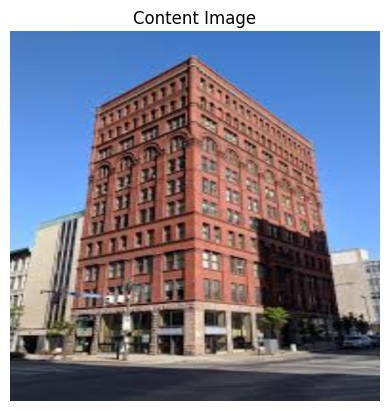

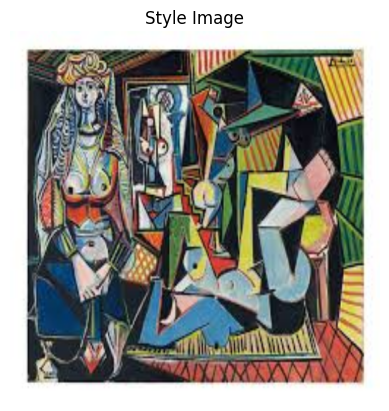

In [ ]:
# Step 2: Load and preprocess images (auto-download version)


import requests
from io import BytesIO


# Download sample content & style images
content_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSkxzYRNyj4y8hYew28aQ918XJpKSJk3eKXxw&s"  # content
style_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzWzjxH_QMj0VBXAGvU-G8EMt6gHc42QaEHw&s" #style

content_image = Image.open(BytesIO(requests.get(content_url).content))
style_image = Image.open(BytesIO(requests.get(style_url).content))

# Define preprocessing transform
image_size = 512
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# Convert to tensors
content_tensor = loader(content_image).unsqueeze(0).to(device) #nn in pytorch expects input in the form (batch_size, channels, height, width)

style_tensor = loader(style_image).unsqueeze(0).to(device)

# Display both images
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

imshow(content_tensor, title="Content Image")
imshow(style_tensor, title="Style Image")


In [ ]:
vgg = models.vgg19(pretrained=True).features

# Freeze the parameters (we don't train VGG)
for param in vgg.parameters():
    param.requires_grad = False

# Move to GPU if available
vgg.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 164MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Define layers for style and content
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Helper function to get VGG feature maps
def get_features(image, model):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [ ]:
content_features = get_features(content_tensor, vgg)
style_features = get_features(style_tensor, vgg)


In [ ]:
def content_loss(generated_features, content_features):
    return torch.mean((generated_features - content_features) ** 2)
def gram_matrix(tensor):
    _, d, h, w = tensor.size()  # d = depth (number of feature maps)
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram
def style_loss(generated_features, style_features):
    loss = 0
    for layer in style_features:
        gen_f = generated_features[layer]
        style_f = style_features[layer]

        G = gram_matrix(gen_f)
        A = gram_matrix(style_f)

        loss += torch.mean((G - A) ** 2)
    return loss


In [ ]:
generated = content_tensor.clone().requires_grad_(True)

# Extract generated features
generated_features = get_features(generated, vgg)

# Compute losses
c_loss = [content_loss(generated_features['conv_4'], content_features['conv_4'])]
s_loss = [style_loss(generated_features, style_features)]

Step 0/500
Style Loss : 131384952.0000  Content Loss: 0.0000
Step 50/500
Style Loss : 4986158.0000  Content Loss: 3.4884
Step 100/500
Style Loss : 2354417.5000  Content Loss: 3.8549
Step 150/500
Style Loss : 1750076.2500  Content Loss: 4.0341
Step 200/500
Style Loss : 1437518.6250  Content Loss: 4.1645
Step 250/500
Style Loss : 1233111.8750  Content Loss: 4.2675
Step 300/500
Style Loss : 1084133.3750  Content Loss: 4.3532
Step 350/500
Style Loss : 968156.6250  Content Loss: 4.4282
Step 400/500
Style Loss : 874258.8750  Content Loss: 4.4908
Step 450/500
Style Loss : 795802.5625  Content Loss: 4.5473


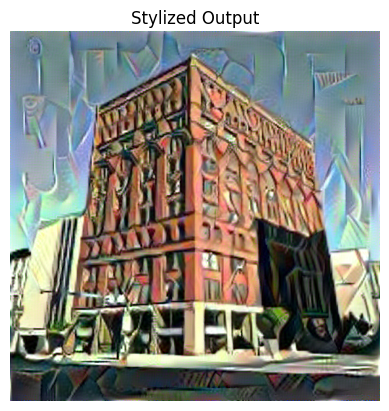

In [ ]:

generated = content_tensor.clone().requires_grad_(True)
optimizer = optim.Adam([generated], lr=0.01)

style_weight = 1e6
content_weight = 1

num_steps = 500
style_losses_list = []
content_losses_list = []

for step in range(num_steps):
    # Keep values between 0–1
    generated.data.clamp_(0, 1)

    optimizer.zero_grad()

    # Extract features
    gen_features = get_features(generated, vgg)

    # Compute content & style loss
    c_loss = content_loss(gen_features['conv_4'], content_features['conv_4'])
    s_loss = style_loss(gen_features, style_features)

    # Combine losses
    total_loss = style_weight * s_loss + content_weight * c_loss

    # Backpropagate and update
    total_loss.backward()
    optimizer.step()

    style_losses_list.append(s_loss.item())
    content_losses_list.append(c_loss.item())

    if step % 50 == 0:
        print(f"Step {step}/{num_steps}")
        print(f"Style Loss : {s_loss.item():.4f}  Content Loss: {c_loss.item():.4f}")

# Clamp final result and display
generated.data.clamp_(0, 1)
imshow(generated, title="Stylized Output")
